# Task 3 QVSM

In this notebook, Quantum Support Vector Machine (QVSM) with one-vs-all method was used to perform multi-class classification on the iris dataset. 

In [ ]:
from sklearn.multiclass import OneVsRestClassifier

from qiskit import Aer
from qiskit.circuit import ParameterVector
from qiskit.circuit import QuantumCircuit
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit_machine_learning.algorithms import QSVC
from qiskit_machine_learning.datasets import iris

/var/folders/_z/8whc27q147x6xf05943qgcj00000gn/T/ipykernel_7159/2901954616.py:8: DeprecationWarning: The iris function is deprecated as of version 0.4.0 and will be removed no sooner than 3 months after the release.
  training_feature, training_label, test_feature, test_label = iris(


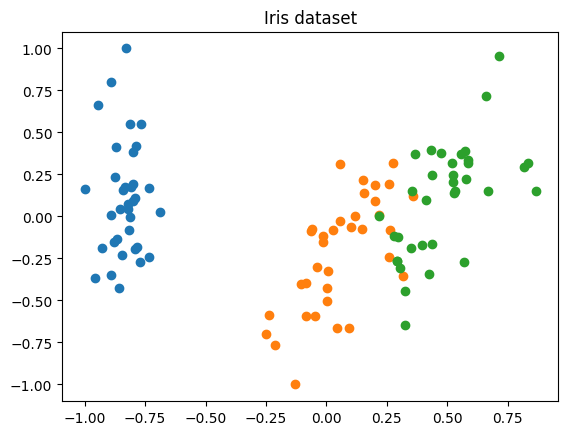

In [2]:
# reduce the dimension so the model requires fewer qubits
iris_dimension = 2
training_size = 35
test_size = 25

# create the training and test sets and visualize the data
# both the training and test sets were normalized and scaled to [-1, 1]
training_feature, training_label, test_feature, test_label = iris(
    training_size=training_size,
    test_size=test_size,
    n=iris_dimension,
    plot_data=True, 
    one_hot=True
)

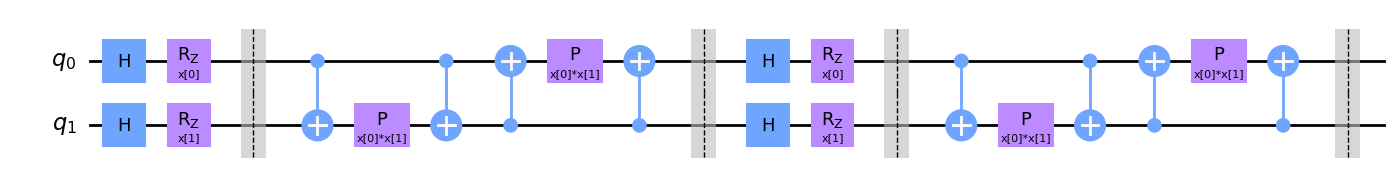

In [3]:
# build the parameterized quantum circuit feature map
qubit_num = iris_dimension
depth = 2
x = ParameterVector('x', length=qubit_num)
feature_map = QuantumCircuit(qubit_num)

for _ in range(depth):
    for i in range(qubit_num):
        feature_map.h(i)
        feature_map.rz(x[i], i)

    feature_map.barrier()
    for i in range(qubit_num):
        if i!=qubit_num-1:
            feature_map.cx(i, i+1)
            feature_map.p(x[i]*x[i+1], i+1)
            feature_map.cx(i, i+1)
        else:
            feature_map.cx(i, 0)
            feature_map.p(x[i]*x[0], 0)
            feature_map.cx(i, 0)
#         feature_map.rx(x[i], i)
#         for j in range(i+1, qubit_num):
#             feature_map.cx(i, j)
#             feature_map.p(x[i]*x[j], j)
#             feature_map.cx(i, j)
    feature_map.barrier()

# visualize the quantum circuit feature map
feature_map.draw('mpl')

In [4]:
# generate the quantum kernel
kernel = QuantumKernel(feature_map=feature_map, quantum_instance=Aer.get_backend('statevector_simulator'))

# train the model
qsvc = QSVC(quantum_kernel=kernel)
ova = OneVsRestClassifier(qsvc)
ova.fit(training_feature, training_label)

OneVsRestClassifier(estimator=QSVC(C=1.0, break_ties=False, cache_size=200,
                                   class_weight=None, coef0=0.0,
                                   decision_function_shape='ovr', degree=3,
                                   gamma='scale', max_iter=-1,
                                   probability=False,
                                   quantum_kernel=<qiskit_machine_learning.kernels.quantum_kernel.QuantumKernel object at 0x169d16b50>,
                                   random_state=None, shrinking=True, tol=0.001,
                                   verbose=False))

In [5]:
predicted_labels = ova.predict(test_feature)
score = ova.score(test_feature, test_label)
# print("Actual label: {}".format(test_label))
# print("Predicted label: {}".format(predicted_labels))
print(f"QSVC classification test score: {score}")

QSVC classification test score: 0.96


A 96% accuracy was achieved with 2 qubits and a depth of 2. 